In [110]:
# model that predicts the lowest value of volatility (VIX) that will be reached in the next 60 days (excluding weekends)
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np



In [111]:

tv = TvDatafeed()
vix = tv.get_hist(symbol="VIX", exchange="CBOE", interval=Interval.in_daily, n_bars=50000)
vix.to_csv('out.csv')

column_names = ['datetime','symbol','open','high','low','close','volume']
dataframe = pd.read_csv("out.csv", header=0)
dataframe['close'] = dataframe['close'].clip(upper=40)

Text(0.5, 1.0, 'VIX Values')

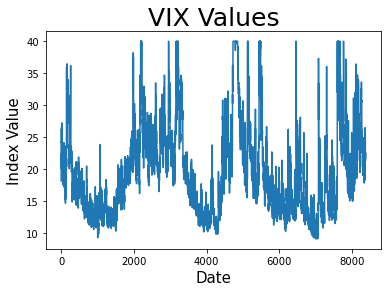

In [112]:
close_data = dataframe['close']

close_data.plot(x="Index Value", y="Step")
plt.xlabel("Date", size=15)
plt.ylabel("Index Value", size=15)
plt.title("VIX Values", size=25)

In [113]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    print(str(data_mean) + " mean")
    print(str(data_std) + " std")
    return (data - data_mean) / data_std, data_mean, data_std


In [114]:
split_ratio = 0.80
train_split = int(split_ratio*close_data.shape[0])
features, meann, stdd = normalize(close_data, train_split)
features = pd.DataFrame(features)
train_length = 180
validation_length = 60
learning_rate= 0.01
step=1
batch_size = 64
#features.head()

19.528144420549566 mean
6.883455521448023 std


<AxesSubplot:>

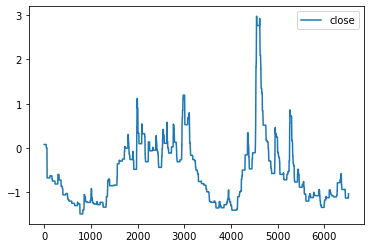

In [115]:
train_data = features.loc[:train_split-1]
validation_data = features.loc[train_split:]


#Model takes first 180 days and predicts the lowest value that will be reached in the next 60 days (excluding weekends)
train_mean_target = []

for i in range(train_length, train_split):
    min_value = train_data[i:i+validation_length].min() # MIN
    train_mean_target.append(min_value)

train_mean_target = pd.DataFrame(train_mean_target)

train_mean_target.plot()

In [116]:
data_train = keras.preprocessing.timeseries_dataset_from_array(
    data=train_data,
    targets=train_mean_target,
    sequence_length=train_length,
    sampling_rate=step,
    batch_size=batch_size
)

In [117]:
validation_mean_target = []

for i in range(train_length, len(validation_data) - validation_length):
    min_value = validation_data[i:i + validation_length].min()
    validation_mean_target.append(min_value)

<AxesSubplot:>

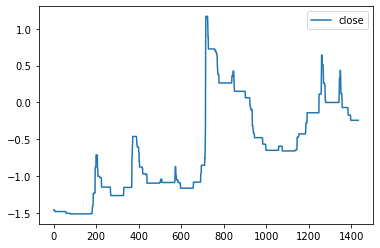

In [118]:
# print(len(validation_mean_target) + len(train_mean_target) + 60 + 180 +180)
# print(len(train_data) + len(validation_data))
# print(len(train_mean_target) + 180)
validation_mean_target = pd.DataFrame(validation_mean_target)
#validation_mean_target.index = dataframe['Date'].iloc[train_split+train_length:-60]
validation_mean_target.plot()

In [119]:
data_train_validation = keras.preprocessing.timeseries_dataset_from_array(
    data=validation_data,
    targets=validation_mean_target,
    sequence_length=train_length,
    sampling_rate=step,
    batch_size = batch_size
)

In [120]:
for batch in data_train.take(1):
    inputs, targets = batch


In [121]:
inputs = keras.layers.Input(shape=(inputs.shape[1],inputs.shape[2]))
lstm_out = keras.layers.LSTM(32, recurrent_dropout=0.3)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)

import keras.backend as k
def loss_function(y_true, y_pred):
    """
    Custom MSE-function that makes predicted values larger than the actual value more punishing.

    """
    loss_tensor = k.mean(k.abs(y_pred - y_true), axis=-1)
    loss_tensor = k.switch(k.greater(y_pred[-1], y_true[-1]), loss_tensor, loss_tensor)
    return loss_tensor

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=loss_function)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 1)]          0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                4352      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [122]:
path_checkpoint = "test_min.h5"
early_stoppage_callback=keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelCheckpoint_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True
)
epochs=30
history = model.fit(
    data_train,
    epochs=epochs,
    validation_data=data_train_validation,
    callbacks=[early_stoppage_callback, modelCheckpoint_callback]
)


Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 0.3607
Epoch 1: val_loss improved from inf to 0.29161, saving model to test_min.h5
102/102 [==============================] - 10s 77ms/step - loss: 0.3607 - val_loss: 0.2916
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 0.3380
Epoch 2: val_loss improved from 0.29161 to 0.27166, saving model to test_min.h5
102/102 [==============================] - 7s 66ms/step - loss: 0.3380 - val_loss: 0.2717
Epoch 3/30
102/102 [==============================] - ETA: 0s - loss: 0.2884
Epoch 3: val_loss improved from 0.27166 to 0.23320, saving model to test_min.h5
102/102 [==============================] - 7s 70ms/step - loss: 0.2884 - val_loss: 0.2332
Epoch 4/30
102/102 [==============================] - ETA: 0s - loss: 0.2863
Epoch 4: val_loss improved from 0.23320 to 0.23243, saving model to test_min.h5
102/102 [==============================] - 7s 65ms/step - loss: 0.2863 - val_loss: 0.2324
Epoch 5/30
102/

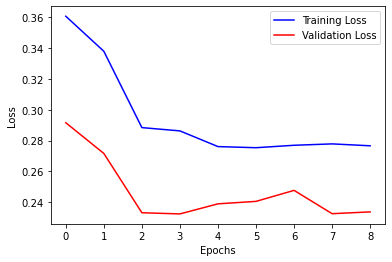

In [123]:
loss = history.history["loss"]
validation_loss = history.history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss , 'b', label="Training Loss")
plt.plot(epochs,validation_loss, 'r', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

2/2 [==============================] - 0s 9ms/step


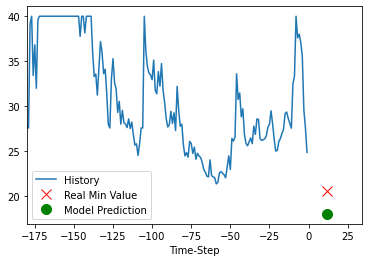

2/2 [==============================] - 0s 9ms/step


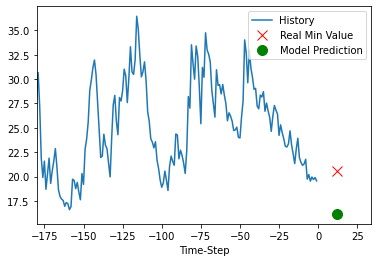

2/2 [==============================] - 0s 10ms/step


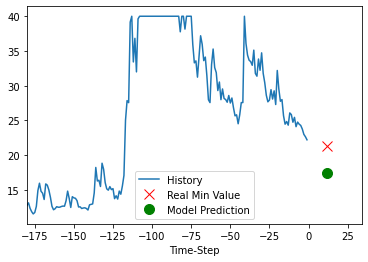

2/2 [==============================] - 0s 11ms/step


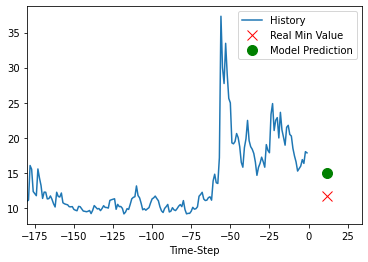

2/2 [==============================] - 0s 10ms/step


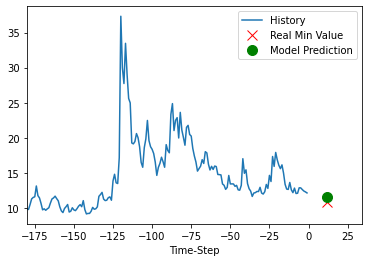

In [124]:
def show_plot(plot_data, delta):
    labels = ["History", "Real Min Value", "Model Prediction"]
    marker = ["-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

def de_normalize(output_data, mean, std):
    return output_data * std + mean

for x, y in data_train_validation.shuffle(555).take(5):
    show_plot([de_normalize(x[0].numpy(), meann, stdd), de_normalize(y[0].numpy(), meann, stdd), de_normalize(model.predict(x)[0], meann, stdd)],12)
